In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import tensorflow_datasets as tfds
import PIL.Image as pilimg
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
root_logdir = os.path.join(os.curdir, "my_tb_logs")

def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d_%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

In [3]:
(train_set, valid_set), info = tfds.load("cars196", split=['train[:80%]', 'train[80%:]'], as_supervised=True, with_info=True)

In [4]:
dataset, test_set = tfds.load("cars196", split=['train', 'test'], as_supervised=True)

In [5]:
dataset_size = info.splits["train"].num_examples

In [6]:
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

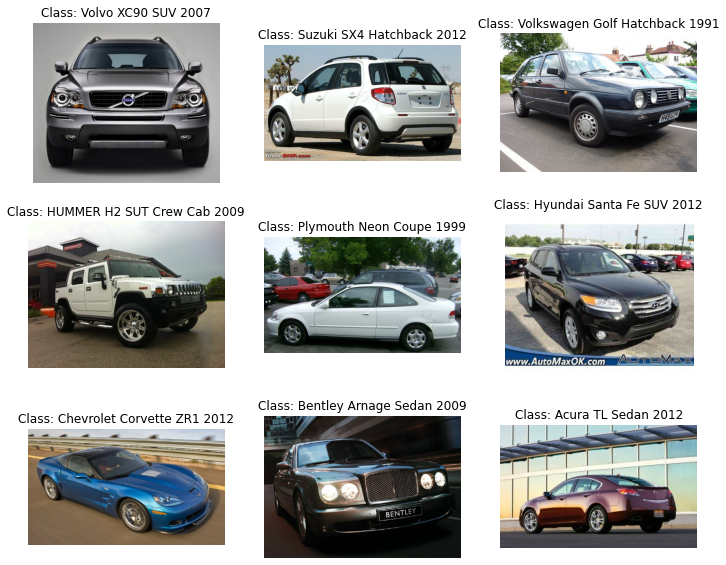

In [7]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in dataset.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

In [9]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False, v3 =False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.mobilenet_v2.preprocess_input(resized_image)
    if v3:
        return final_image, label
    else:
        return resized_image, label

In [10]:
from functools import partial

In [14]:
def batchsize(batch_size, shuffle=True):
    if shuffle:
        trainset = train_set.shuffle(1000).repeat()
        trainset = trainset.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
    else:
        trainset = train_set.map(preprocess).batch(batch_size).prefetch(1)
    return trainset

In [15]:
batch_size=8
batchsize(8)
valid_set = valid_set.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set.map(preprocess).batch(batch_size).prefetch(1)

In [16]:
train_1 = batchsize(8)

In [17]:
train_2 = batchsize(8, shuffle=False)

In [ ]:
for image, label in train_1.take(1):
    for index in range(8):
        plt.subplot(2, 4, index + 1)
        plt.imshow(image[index] / 255)
        plt.axis("off")
plt.show()

In [ ]:
for i in range(1,11):
    for index in range(8):
        for image, label in train_2.take(i):
            plt.subplot(2, 4, index+1)
            plt.imshow(image[index]/255)
            plt.axis("off")
    plt.show()    

In [18]:
base_model = keras.applications.mobilenet_v2.MobileNetV2(input_shape = (224, 224, 3), weights="imagenet",include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [19]:
for layer in base_model.layers:
    layer.trainable = False
optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [22]:
batch_size = 16
history = model.fit(batchsize(batch_size),
                    steps_per_epoch=int(0.8 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.2 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
407/407 [==============================] - 23s 51ms/step - loss: 4.2135 - accuracy: 0.2440 - val_loss: 7.4219 - val_accuracy: 0.0579
Epoch 2/5
407/407 [==============================] - 22s 54ms/step - loss: 4.0883 - accuracy: 0.2345 - val_loss: 7.3883 - val_accuracy: 0.0548
Epoch 3/5
407/407 [==============================] - 22s 54ms/step - loss: 4.0107 - accuracy: 0.2455 - val_loss: 7.2704 - val_accuracy: 0.0567
Epoch 4/5
407/407 [==============================] - 25s 63ms/step - loss: 3.9089 - accuracy: 0.2525 - val_loss: 7.2115 - val_accuracy: 0.0530
Epoch 5/5
407/407 [==============================] - 28s 69ms/step - loss: 3.8282 - accuracy: 0.2561 - val_loss: 7.2287 - val_accuracy: 0.0530


In [24]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
es = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
tb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(batchsize(batch_size),
                    steps_per_epoch=int(0.8 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.2 * dataset_size / batch_size),
                    epochs=40, callbacks=[es, tb])

Epoch 1/40
407/407 [==============================] - 80s 173ms/step - loss: 5.4988 - accuracy: 0.0054 - val_loss: 7.8564 - val_accuracy: 0.0037
Epoch 2/40
407/407 [==============================] - 72s 178ms/step - loss: 5.2901 - accuracy: 0.0100 - val_loss: 6.5344 - val_accuracy: 0.0062
Epoch 3/40
407/407 [==============================] - 73s 178ms/step - loss: 5.1475 - accuracy: 0.0154 - val_loss: 5.6633 - val_accuracy: 0.0124
Epoch 4/40
407/407 [==============================] - 73s 179ms/step - loss: 4.8385 - accuracy: 0.0299 - val_loss: 5.3679 - val_accuracy: 0.0186
Epoch 5/40
407/407 [==============================] - 73s 178ms/step - loss: 4.4473 - accuracy: 0.0600 - val_loss: 5.2152 - val_accuracy: 0.0297
Epoch 6/40
407/407 [==============================] - 73s 179ms/step - loss: 3.9487 - accuracy: 0.1156 - val_loss: 4.6181 - val_accuracy: 0.0545
Epoch 7/40
407/407 [==============================] - 73s 179ms/step - loss: 3.4339 - accuracy: 0.1907 - val_loss: 4.2225 - val_ac